In [18]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]
%matplotlib inline
%config InlineBackend.figure_format='retina'
from tqdm import tqdm

from scipy import integrate
from scipy.stats import norm
from astroML.plotting import hist
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)

import warnings; warnings.simplefilter('ignore')
import corner
import emcee
import time

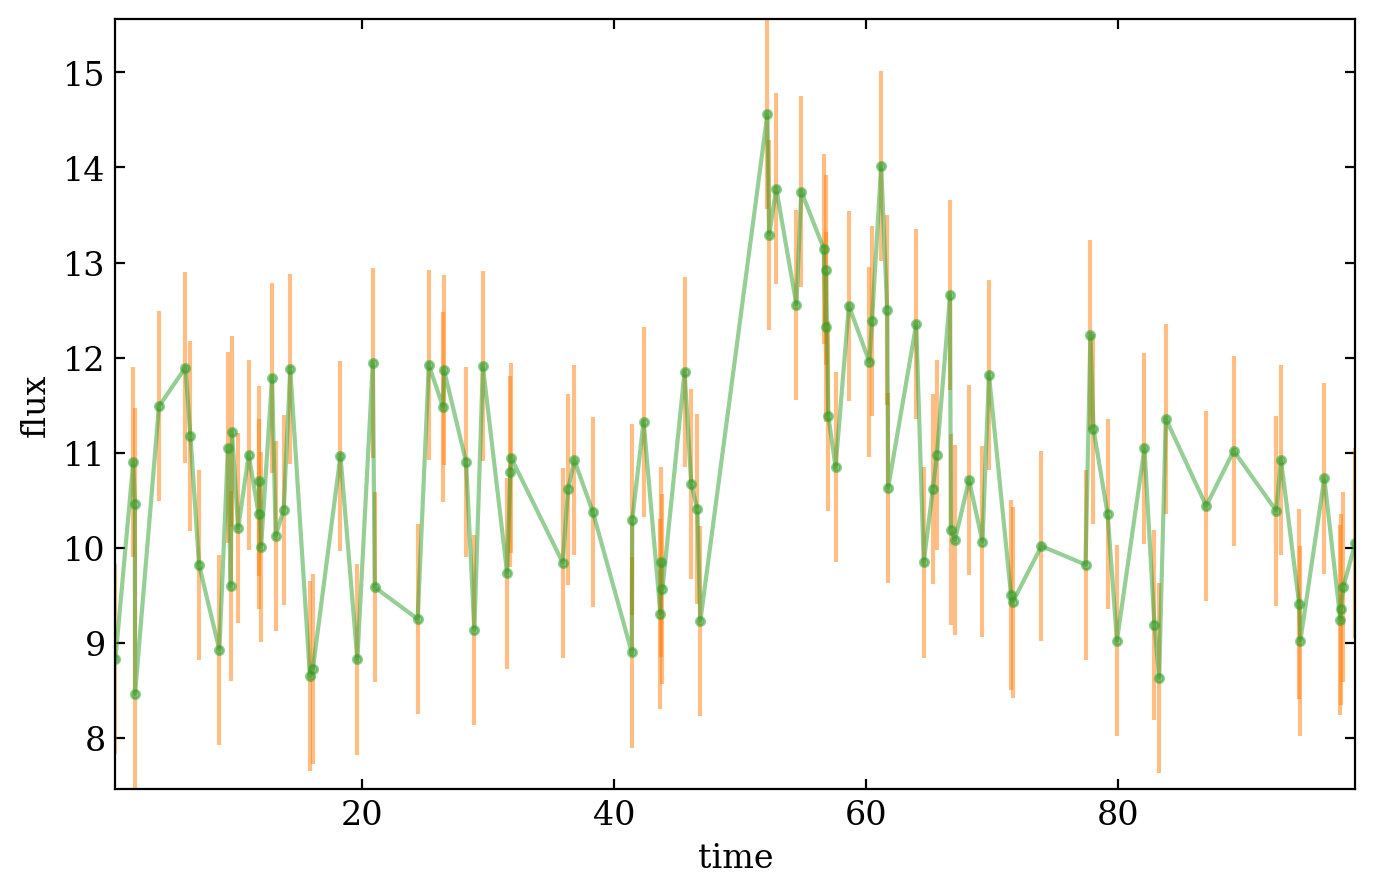

In [19]:
np.random.seed(0)
t = np.load('transient.npy')[:,0]
flux = np.load('transient.npy')[:,1]
err = np.load('transient.npy')[:,2]
tgrid = np.linspace(min(t),max(t),100)
plt.errorbar(t, flux, err, ecolor='C1', capthick=0, marker='.', c='C2',alpha=0.5)
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

In [20]:
def sharp_burst(t, param):
    y=np.zeros(len(t))
    b = param[0]
    A = param[1]
    t0 = param[2]
    alpha = param[3]
    y[t<t0]=b
    y[t>=t0]= A*np.exp(-alpha*(t[t>=t0]-t0)) + b
    return y  

def Likelihood(x, t, flux, err):
    return np.prod(np.exp(-((flux - sharp_burst(t, x))**2)/(2*err**2)))

def Prior_b(x):
    if (0<x<50):
        return 1.0 / 50
    else:
        return 0

def Prior_A(x):
    if (0<x<50):
        return 1.0 / 50
    else:
        return 0
    
def Prior_t0(x):
    if (0<x<100):
        return 1.0 / 100
    else:
        return 0

def Prior_alpha(x):
    if (-5<np.log(x)<5):
        return 1.0 / (10*x)
    else:
        return 0

def Posterior(x, t, flux, err):
    return Likelihood(x,t,flux,err)*Prior_b(x[0])*Prior_A(x[1])*Prior_t0(x[2])*Prior_alpha(x[3])

def LogPosterior(x, t, flux, err):
    lp=np.log(Posterior(x, t, flux, err))
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp

Value of the LogLikelihood :  -51.488086205373705


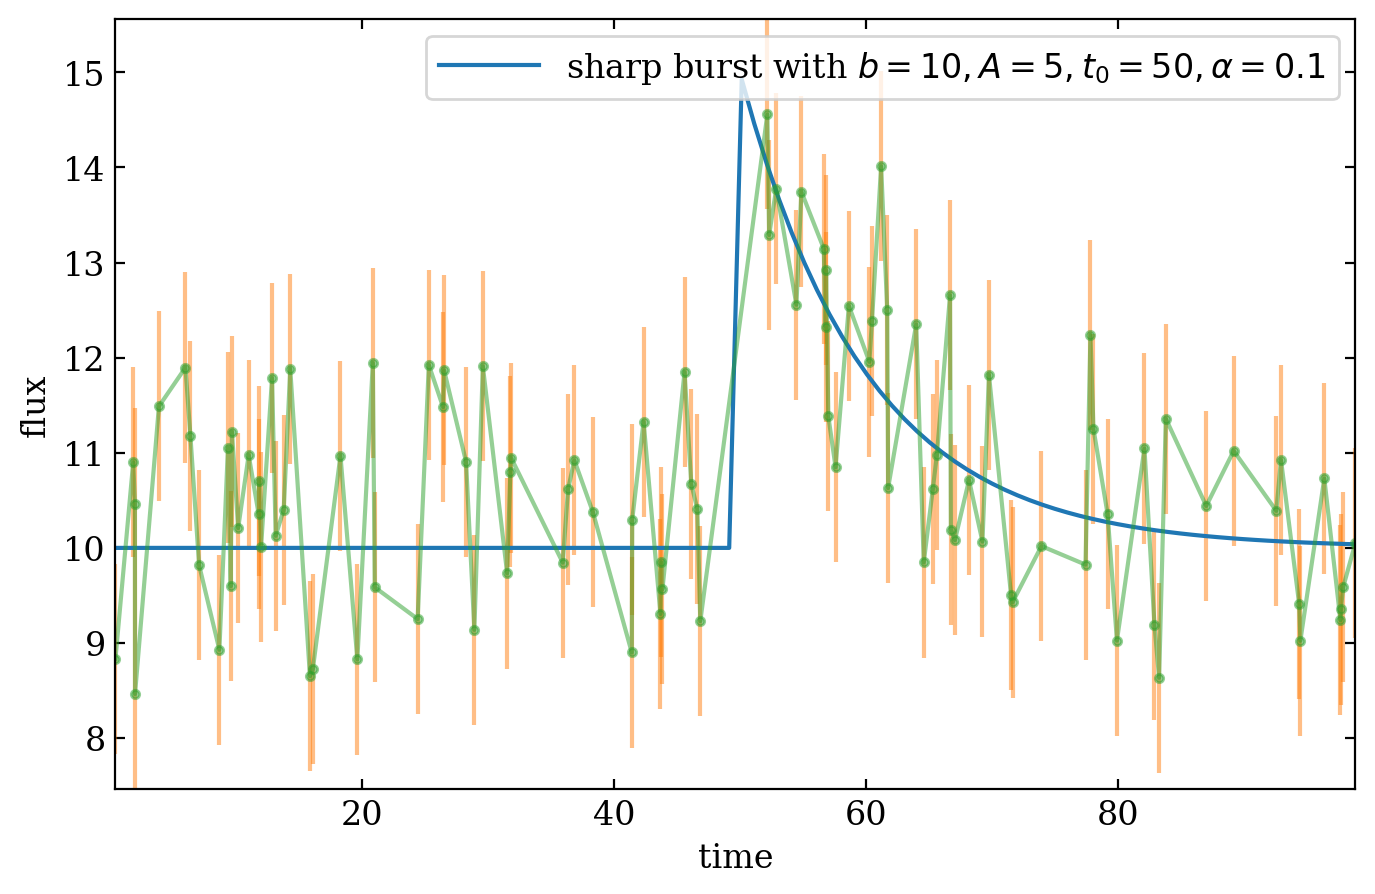

In [21]:
plt.errorbar(t, flux, err, ecolor='C1', capthick=0, marker='.', c='C2', alpha=0.5)
naive_param = [10, 5, 50, 0.1] #found by looking by eye at the max value of the LogLikelihood
plt.plot(tgrid, sharp_burst(tgrid, naive_param ), c='C0', label=r'sharp burst with $b=10, A=5, t_0=50, \alpha=0.1$')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()
print('Value of the LogLikelihood : ', np.log(Likelihood(naive_param, t,flux,err)))
plt.show()


In [22]:
ndim = 4 # number of parameters in the model
nwalkers = 50 # number of MCMC walkers 
burn = 1000 # "burn-in" period to let chains stabilize
nsteps = 10000  # number of MCMC steps to take **for each walker**
labels=[r'$b$', r'$A$', r'$t_0$', r'$\alpha$']

# initialize parameters:
# uniform distribution centered in the naive values +- (1/100 of the prior distribution interval)
sg_b = np.random.uniform(9.5,10.5, nwalkers) 
sg_A = np.random.uniform(4.5,5.5, nwalkers)
sg_t0 = np.random.uniform(49,51, nwalkers)
sg_alpha = np.exp(np.random.uniform(-2.4,-2.2, nwalkers)) # ln(0.1)=-2.3
starting_guesses = np.column_stack((sg_b, sg_A, sg_t0, sg_alpha))

sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, args=[t,flux,err])
sampler.run_mcmc(starting_guesses, nsteps)
 
#correleted time
tau = sampler.get_autocorr_time()
#trace
emcee_trace = sampler.get_chain(discard=burn, thin=np.max(tau).astype(int), flat=True)

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  4.88it/s]


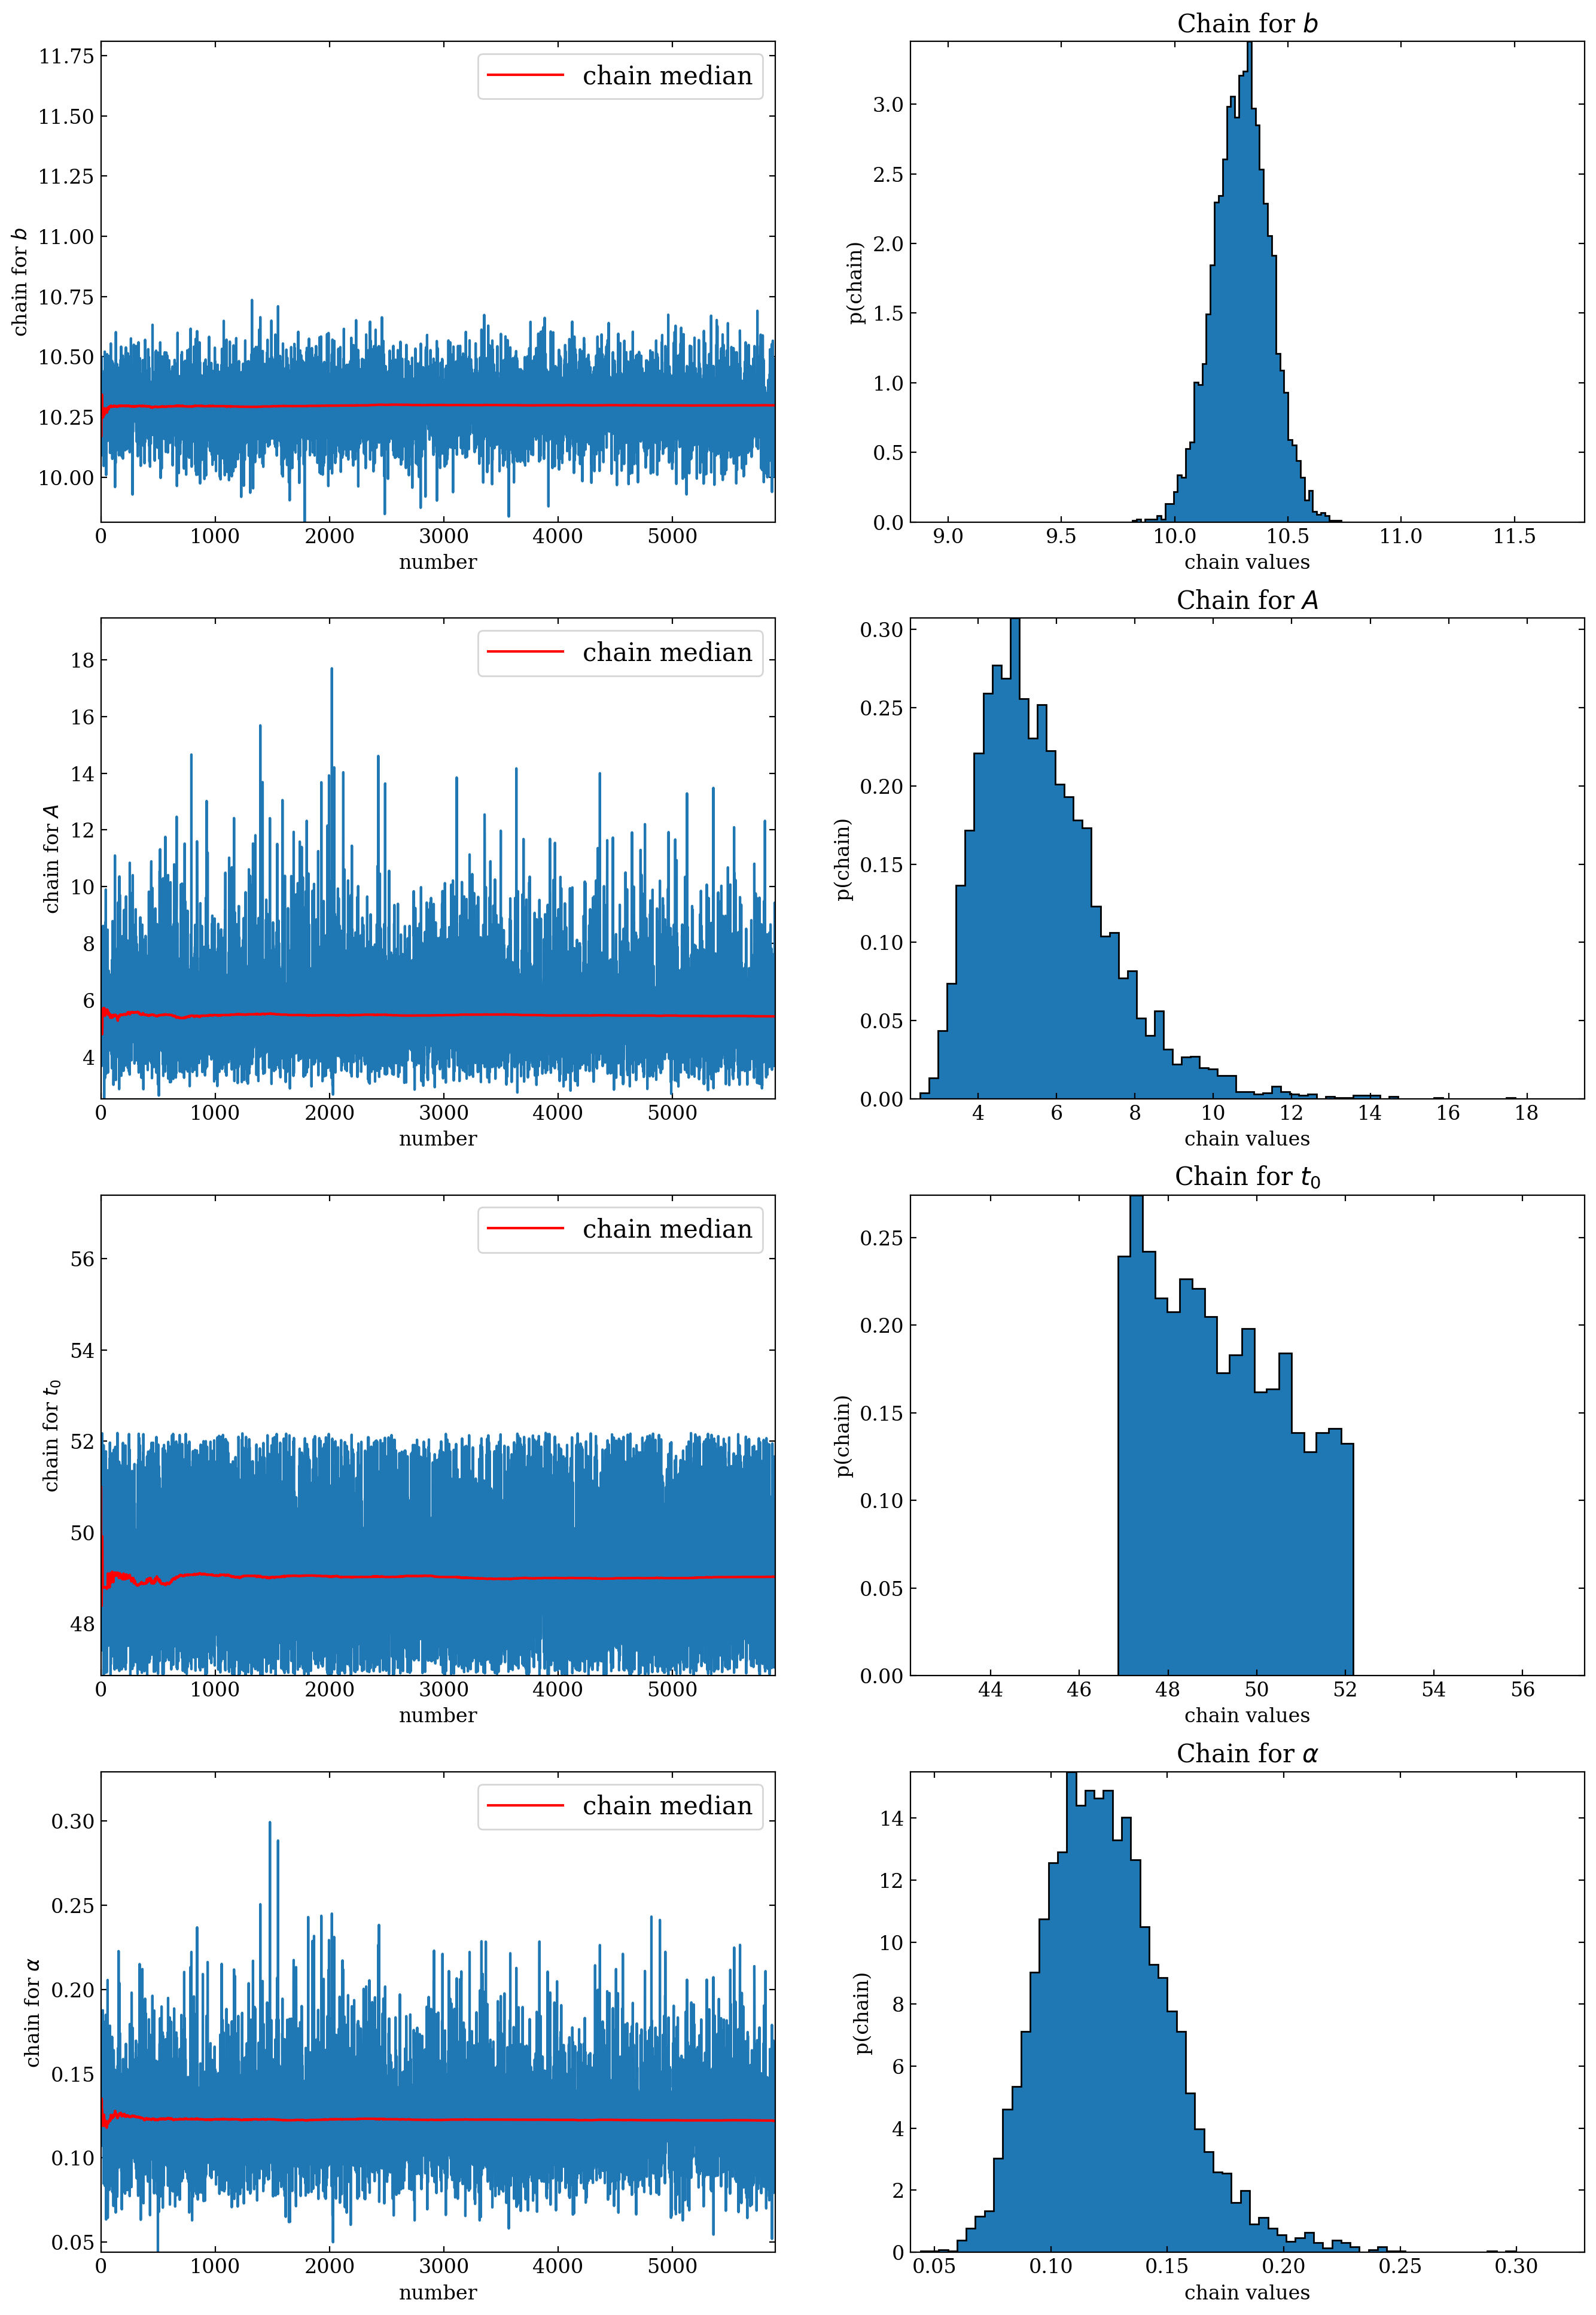

In [23]:
fig = plt.figure(figsize=(16, 24))

for i in tqdm(range(4)):
    chain = emcee_trace[:,i]
    M = np.size(chain)
    ax1 = fig.add_subplot(4,2,2*i+1)
    xgrid = np.linspace(1, M, M)
    plt.plot(xgrid, chain)
    ax1.axis([0, M, np.min(chain), 1.1*np.max(chain)])
    plt.xlabel('number')
    plt.ylabel('chain for '+labels[i])

    medianC = [np.median(chain[:int(N)]) for N in xgrid]
    ax1.plot(xgrid, medianC, c='red', label='chain median')
    ax1.legend(fontsize=15)

    ax2 = fig.add_subplot(4,2,2*(i+1))
    Nchain = np.size(chain)
    Nhist, bins, patches = plt.hist(chain, density=True, 
                                    bins='auto', histtype='stepfilled')
    
   
    ax2.set_ylabel('p(chain)')
    ax2.set_xlabel('chain values')
    ax2.set_xlim(np.min(chain)*0.9,np.max(chain)*1.1)
    ax2.set_title(r'Chain for '+labels[i], fontsize=15)

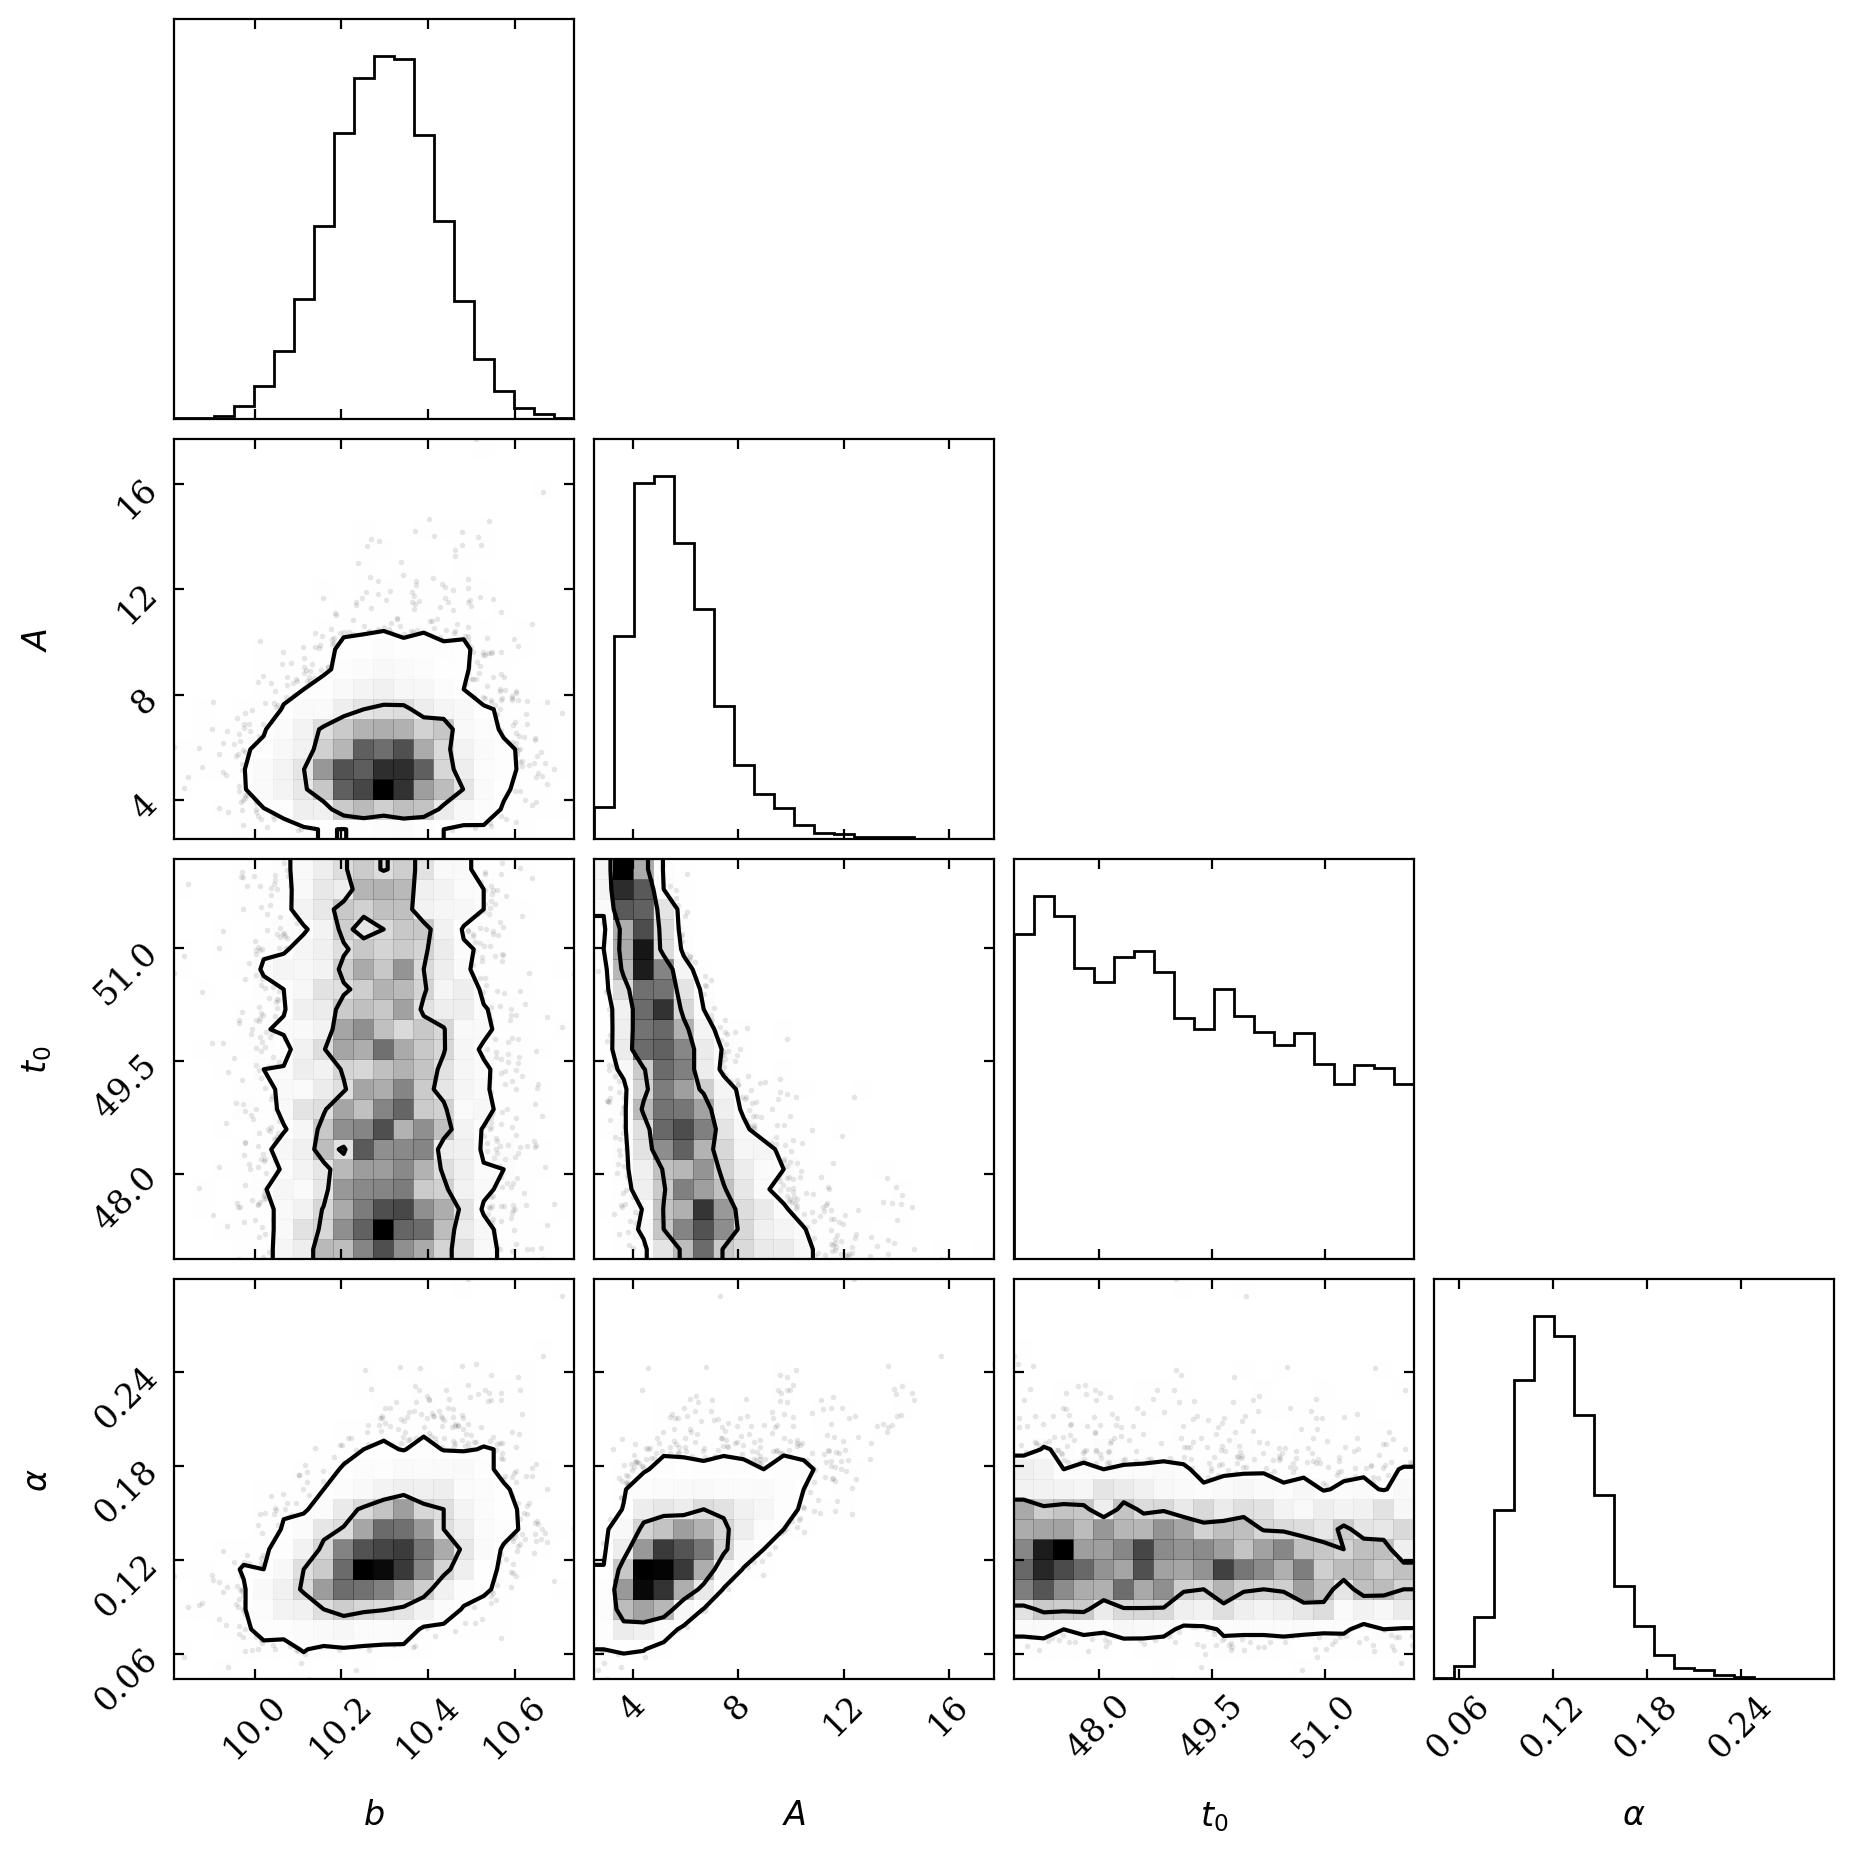

In [24]:
corner.corner(emcee_trace, labels=labels, levels=[0.68,0.95]);

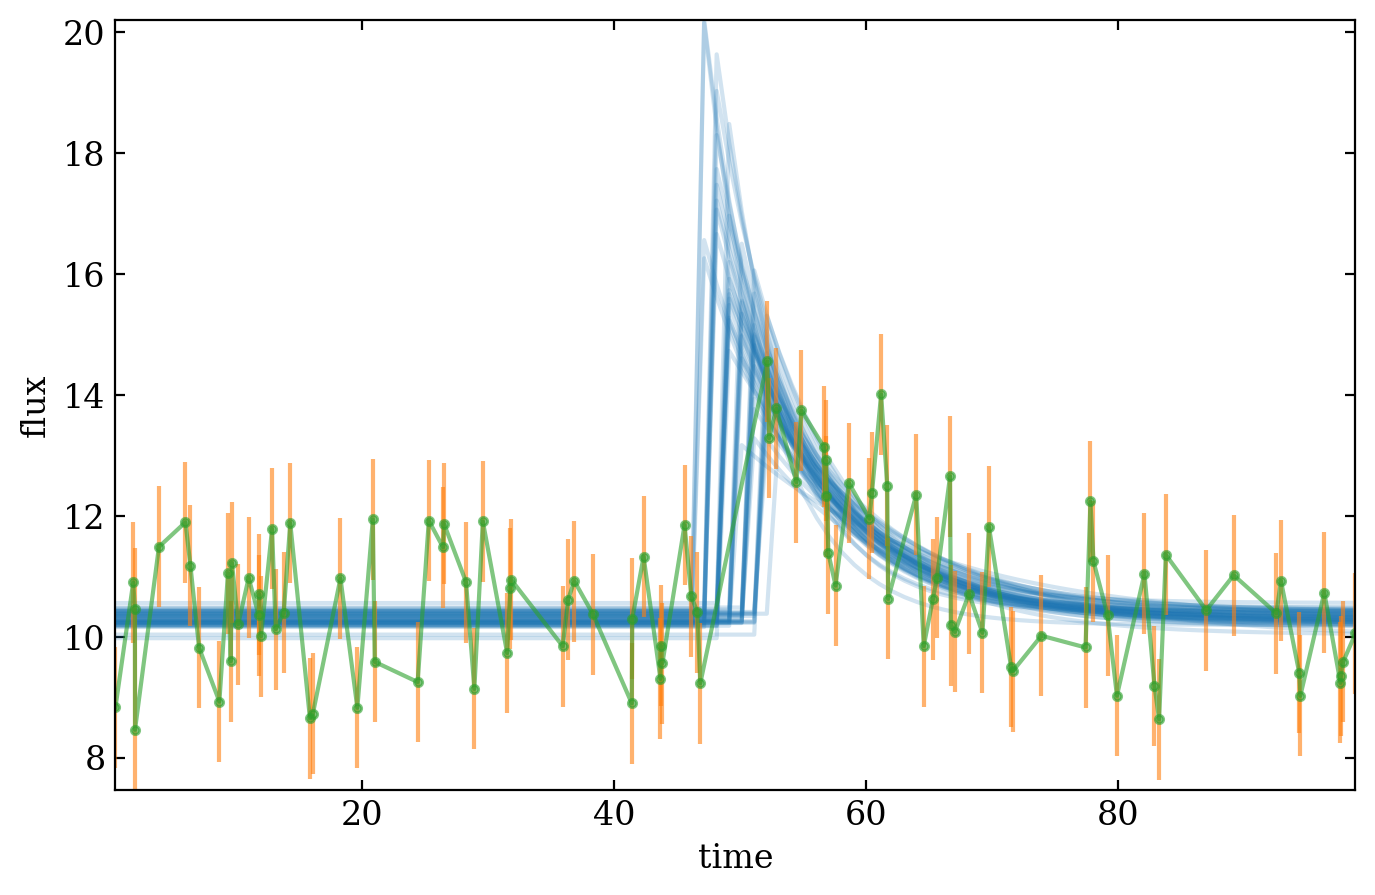

In [25]:
sample_ind = np.random.randint(0, len(emcee_trace), 50)
chain_sample=emcee_trace[sample_ind]

for par in chain_sample:
    plt.plot(tgrid, sharp_burst(tgrid, par), alpha=0.2, c='C0')
plt.errorbar(t, flux, err, ecolor='C1', capthick=0, marker='.', c='C2', alpha=0.6)
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

Results: 

b:   10.298   + 0.197   - 0.207
A:   5.424   + 3.352   - 1.837
t0:   49.032   + 2.777   - 1.968
alpha:   0.122   + 0.051   - 0.038

LogPosterior = -61.45


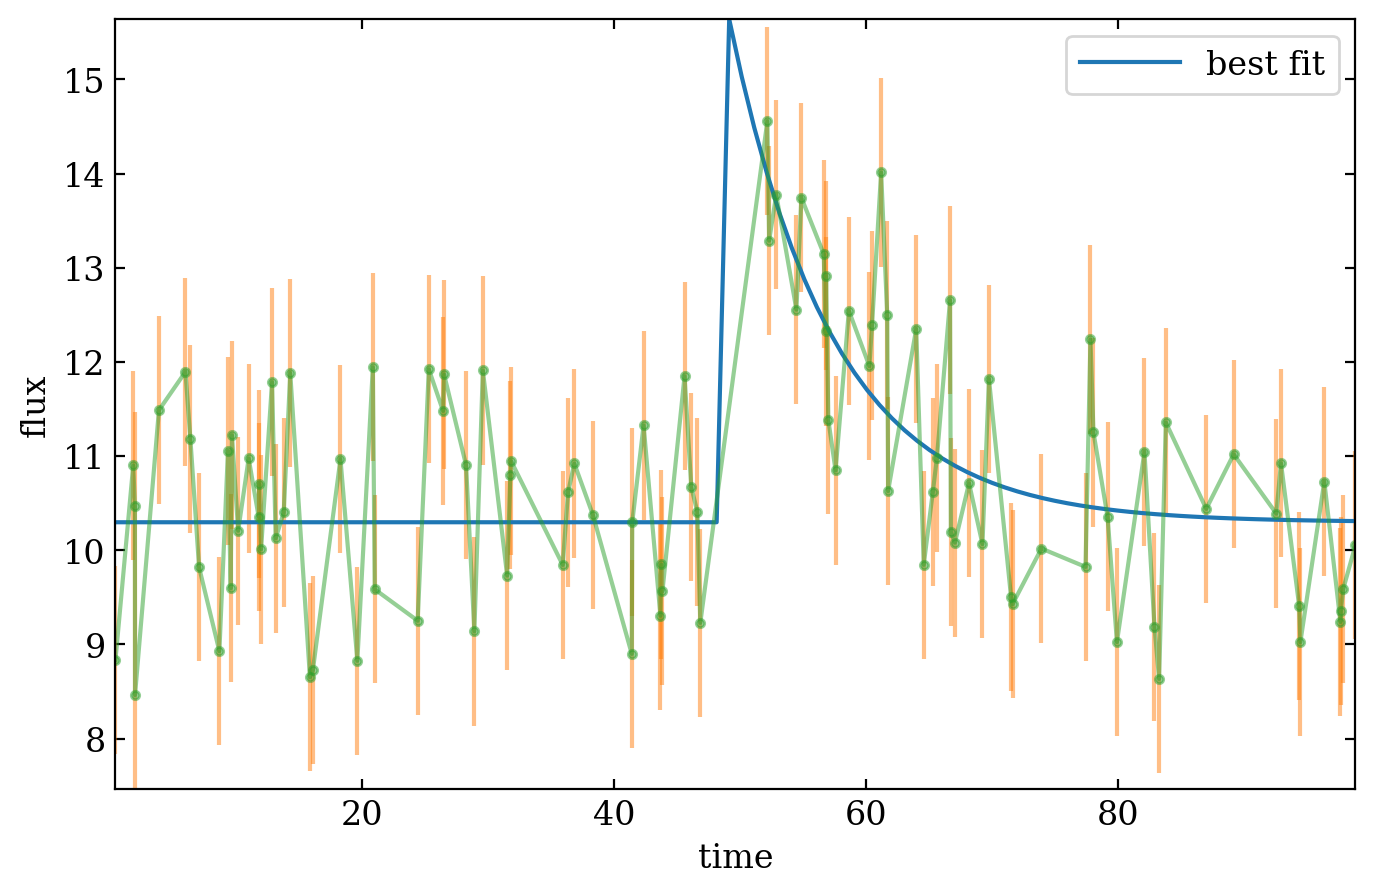

In [26]:
print('Results: \n')
best_param = np.array([])
for i, l in zip(range(ndim),['b','A','t0','alpha']):
    chain=emcee_trace[:,i]
    X=np.median(chain)
    p5, p95 = np.percentile(chain, [5,95])
    print(l+':  ', round(X,3), '  +', round(p95-X,3), '  -', round(X-p5,3))
    best_param = np.append(best_param, X)
    
print('\nLogPosterior =', round(sampler.compute_log_prob(best_param[np.newaxis,:])[0].item(),3))
best_model = sharp_burst(tgrid, best_param)
plt.errorbar(t, flux, err, ecolor='C1', capthick=0, marker='.', c='C2',alpha=0.5)
plt.plot(tgrid, best_model, c='C0', label='best fit')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()
plt.show()